people on the samge group are one the same side

In [298]:
import pandas as pd
import numpy as np

df = pd.read_csv('pre_processed.csv')


In [299]:
def fill_deck_and_side_from_cabin(df):
    # Define a mask to identify rows where 'Number' is NaN and 'Cabin' is not NaN
    mask = df['Number'].isna() & df['Cabin'].notna()
    
    # Use the mask to update only the filtered rows, converting types appropriately
    df.loc[mask, ['Deck', 'Number', 'Side']] = df.loc[mask, 'Cabin'].apply(
        lambda x: pd.Series({
            'Deck': x.split('/')[0],
            'Number': int(x.split('/')[1]),  # Explicit conversion to integer here
            'Side': x.split('/')[2]
        })
    )

    return df

In [300]:
decks_by_planet = {
    'Earth':['E','F','G'],
    'Europa': ['A','B','C','D','E','T'],
    'Mars': ['D','E','F']
}

decks_by_planet_no_bills = {
    'Earth':['G'],
    'Europa':['B'],
    'Mars': ['E','F']
}

planet_by_deck = {
    'A':['Europa'],'B':['Europa'],'C':['Europa'],'D':['Europa','Mars'],'E':['Europa','Mars','Earth'],
    'F':['Earth','Mars'],'G':['Earth'],'T':['Europa']
}

homeplanets = ['Earth', 'Europa', 'Mars']

all_cabin_sides = ['P','S']

all_cabin_decks = list(df.dropna(subset = ['Deck']).Deck.unique())


In [301]:
def multiple_decks_in_group(df,row):
    return len(df[df.Group == row.Group].dropna(subset ='Deck').Deck.unique()) > 1
        

In [302]:
def fill_potential_decks(df):
    def func_potential_decks(row):
        if pd.isna(row.Cabin):
            if row.Bills == 0 and not pd.isna(row.HomePlanet):
                if len(df[df.Group == row.Group].dropna(subset = 'Deck').Deck.unique()) > 1:
                    return decks_by_planet_no_bills[row.HomePlanet]
            if not pd.isna(row.HomePlanet):
                return decks_by_planet[row.HomePlanet]
            else:
                return all_cabin_decks
    df['potential_decks'] = df.apply(func_potential_decks, axis = 1)
    return df

In [303]:
df = fill_potential_decks(df)

# Filling missed Cabins


In [304]:
def dict_of_utilised_cabins(df):
    used_cabins = {}
    for deck in all_cabin_decks:
        cab = {}
        for side in all_cabin_sides:
            rooms = list(df[(df.Deck == deck) & (df.Side == side)].dropna(subset = 'Number').Number.unique())
            rooms.sort()
            cab[side] = rooms
        used_cabins[deck] = cab
    return used_cabins
    

#### fill people that must be sharing a room with people in the same group
ie, from their chome planet we know the decks they could be in, if the side and number below and above are one above and one below then they must be sharing with someone from their group. make sure that their group has only one cabin

need to make sure is only one person  with cabin being na in the group otherwise one na might be in another cabin 

for row in dataframe

if cabin.isna() and homeplanet is known,
 for potential decks in homeplanets remit ie europa check a, b , c in dataframe up to that point and over that point, see if any have a free space and if not then fill it with the one in the same group

In [305]:
def checks(df):
    for home in homeplanets:
        print("\n" + home)
        print(df[df.HomePlanet == home].Deck.value_counts())
    return df

In [306]:
df.to_csv('before_impute.csv',index = False)

In [307]:
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()

Finding groups that have more than 1 member that all share the same cabin and that dont have other nans in group

In [308]:
df2.isna().sum()

PassengerId            0
HomePlanet            13
CryoSleep            310
Cabin                299
Destination          274
Age                  270
VIP                  296
RoomService          263
FoodCourt            289
ShoppingMall         306
Spa                  284
VRDeck               268
Name                 294
Set                    0
Transported         4277
Group                  0
GroupNumber            0
Deck                 299
Number               299
Side                 299
FirstName            294
LastName             294
GroupSize              0
Bills                785
potential_decks    12671
dtype: int64

## empty room with only one comptabile


should modify so that if there are multiple but its the sole member of its group it should take it 


In [347]:
def rooms_to_fill(df):
    rooms = {}
    for deck in all_cabin_decks:
        for side in all_cabin_sides:
            rooms_seen = list(df[(df.Deck == deck) & (df.Side == side)].dropna(subset = ['Number']).Number.unique())
            largest_room_number = int(max(list(df[(df.Deck == deck) & (df.Side == side)].dropna(subset = ['Number']).Number.unique())))
            for i in range(largest_room_number):
                if i not in rooms_seen:
                    if deck not in rooms:
                        rooms[deck] = {'P':[],'S':[]}
                    rooms[deck][side].append(i)
    return rooms

                    
                    
                    
            

In [349]:

def empty_room_one_compatible(df):
    count = 0
    empty_cabins = rooms_to_fill(df) 
    for deck in empty_cabins.keys():
        for side in empty_cabins[deck].keys():
            for number in empty_cabins[deck][side]:
                print("count",count)
                count +=1
                indices_of_compatible_rows = []
                temp = df[(df.Cabin.isna())]
                for index,row in temp.iterrows():
                    if deck not in row.potential_decks:
                        continue
                            
                    before_slice = df.iloc[:index]
                    after_slice = df.iloc[index+1:] 
                    before = list(before_slice[(before_slice.Deck == deck) & (before_slice.Side == side)].Number.unique())
                    if len(before) > 0:
                        if max(before) < number:
                            if min(list(after_slice[(after_slice.Deck == deck) & (after_slice.Side == side)].Number.unique())) > number:
                                indices_of_compatible_rows.append(index)
                if len(indices_of_compatible_rows) == 1:
                    df.loc[indices_of_compatible_rows[0], 'Cabin'] = deck + "/" + str(int(number)) + "/" + side

    df = fill_deck_and_side_from_cabin(df)
    return df
                    
                    
                        

In [367]:
df2 = empty_room_one_compatible(df2)



count 0
count 1
count 2
count 3
count 4
count 5
count 6
count 7
count 8
count 9
count 10
count 11
count 12
count 13
count 14
count 15
count 16
count 17
count 18
count 19
count 20
count 21
count 22
count 23
count 24
count 25
count 26


In [368]:
df2.isna().sum()

PassengerId            0
HomePlanet            13
CryoSleep            310
Cabin                 66
Destination          274
Age                  270
VIP                  296
RoomService          263
FoodCourt            289
ShoppingMall         306
Spa                  284
VRDeck               268
Name                 294
Set                    0
Transported         4277
Group                  0
GroupNumber            0
Deck                  66
Number                66
Side                  66
FirstName            294
LastName             294
GroupSize              0
Bills                785
potential_decks    12671
dtype: int64

## No free rooms left so shares

In [369]:
def no_free_rooms_so_shares_3(df):
    count = 0
    for index, passenger in df[df.Cabin.isna()].iterrows():
        options = []
        for deck in passenger.potential_decks:
            for side in all_cabin_sides:
                
                before_slice = df.iloc[:index]
                after_slice = df.iloc[index+1:] 
                top_room = before_slice[(before_slice.Deck == deck) & (before_slice.Side == side)].Number
                if len(top_room) > 0:
                    top_room_number_before = max(top_room)
                else:
                    top_room_number_before = -1
                smallest_room = after_slice[(after_slice.Deck == deck) & (after_slice.Side == side)].Number
                
                if len(smallest_room) > 0:
                    smallest_room_number_after = min(smallest_room)
                else:
                    smallest_room_number_after = 1000
                if top_room_number_before + 1 < smallest_room_number_after:   
                        options.append([deck,side,top_room_number_before,smallest_room_number_after])
        if len(options) == 0:
            print(count)
            print(len(df[(df.Group == passenger.Group) & (df.Deck.isin(passenger.potential_decks))].dropna(subset = 'Cabin').Cabin.unique()))
            if len(df[(df.Group == passenger.Group) & (df.Deck.isin(passenger.potential_decks))].dropna(subset = 'Cabin').Cabin.unique()) == 1:
                df.loc[index,'Cabin'] = df[(df.Group == passenger.Group) & (df.Deck.isin(passenger.potential_decks))].dropna(subset = 'Cabin').Cabin.iloc[0]
            count += 1
    df = fill_deck_and_side_from_cabin(df)

    
    return df
    


In [370]:
df2 = no_free_rooms_so_shares_3(df2)

0
3
1
3
2
2
3
2
4
2


In [371]:
df2.isna().sum()

PassengerId            0
HomePlanet            13
CryoSleep            310
Cabin                 66
Destination          274
Age                  270
VIP                  296
RoomService          263
FoodCourt            289
ShoppingMall         306
Spa                  284
VRDeck               268
Name                 294
Set                    0
Transported         4277
Group                  0
GroupNumber            0
Deck                  66
Number                66
Side                  66
FirstName            294
LastName             294
GroupSize              0
Bills                785
potential_decks    12671
dtype: int64

# in a group of one and only one option

In [372]:
def solo_group_and_one_option(df):
    empty_cabins = rooms_to_fill(df) 
    
    for index,passenger in df[(df.GroupSize == 1) & (df.Cabin.isna())].iterrows():
        print()
        print("index",index)
        options = []
        for deck in empty_cabins.keys():
            if deck not in passenger.potential_decks:
                continue
            for side in empty_cabins[deck]:
                for number in empty_cabins[deck][side]:
                    before_slice = df.iloc[:index]
                    after_slice = df.iloc[index+1:] 
                    top_room = before_slice[(before_slice.Deck == deck) & (before_slice.Side == side)].Number
                    if len(top_room) > 0:
                        top_room_number_before = max(top_room)
                    else:
                        top_room_number_before = -1
                    smallest_room = after_slice[(after_slice.Deck == deck) & (after_slice.Side == side)].Number
                    
                    if len(smallest_room) > 0:
                        smallest_room_number_after = min(smallest_room)
                    else:
                        smallest_room_number_after = 1000
                    if top_room_number_before < number:
                        if smallest_room_number_after > number:
                            options.append([deck,side,top_room_number_before,smallest_room_number_after])
                        else:
                            print("srna",smallest_room_number_after,number)
                        
                            
                    else:
                        print("trnb",top_room_number_before,number)   
                            
        print(options)
                            
        if len(options) == 1:
            if options[0][2] + 2 == options[0][3]:
                print()
                df.loc[index,'Cabin'] = options[0][0] + "/" + str(int(options[0][2]) + 1) + "/" + options[0][1]
                print("found",index,options)
            else:
                print()
                print("multigap")
                print(index,options)
    df = fill_deck_and_side_from_cabin(df)
    
    return df
                
                    
                    

In [373]:
df2 = solo_group_and_one_option(df2)


index 404
srna 3.0 94
srna 14.0 40
srna 14.0 270
srna 14.0 298
srna 17.0 20
srna 17.0 21
srna 17.0 58
srna 17.0 150
srna 17.0 387
srna 18.0 528
srna 11.0 191
srna 11.0 235
srna 11.0 36
[['B', 'P', 12.0, 14.0], ['C', 'S', 12.0, 14.0]]

index 421
srna 4.0 94
srna 14.0 40
srna 14.0 270
srna 14.0 298
srna 17.0 20
srna 17.0 21
srna 17.0 58
srna 17.0 150
srna 17.0 387
srna 20.0 528
srna 12.0 191
srna 12.0 235
srna 11.0 36
[['B', 'P', 12.0, 14.0], ['C', 'S', 12.0, 14.0]]

index 1466
trnb 37.0 13
srna 8.0 94
trnb 39.0 13
srna 41.0 270
srna 41.0 298
trnb 57.0 20
trnb 57.0 21
srna 59.0 150
srna 59.0 387
srna 75.0 528
srna 40.0 191
srna 40.0 235
[['C', 'S', 39.0, 41.0], ['E', 'P', 57.0, 59.0], ['D', 'S', 35.0, 37.0]]

index 1543
trnb 38.0 13
srna 9.0 94
trnb 39.0 13
srna 41.0 270
srna 41.0 298
trnb 61.0 20
trnb 61.0 21
trnb 61.0 58
srna 62.0 150
srna 62.0 387
srna 76.0 528
srna 43.0 191
srna 43.0 235
[['C', 'S', 39.0, 41.0], ['D', 'S', 35.0, 37.0]]

index 3529
srna 520.0 1489
srna 520.0 1544
srn

In [374]:
df2.isna().sum()

PassengerId            0
HomePlanet            13
CryoSleep            310
Cabin                 66
Destination          274
Age                  270
VIP                  296
RoomService          263
FoodCourt            289
ShoppingMall         306
Spa                  284
VRDeck               268
Name                 294
Set                    0
Transported         4277
Group                  0
GroupNumber            0
Deck                  66
Number                66
Side                  66
FirstName            294
LastName             294
GroupSize              0
Bills                785
potential_decks    12671
dtype: int64

In [365]:
df2.loc[4233,'Cabin'] = 'B/98/P'
df2.loc[4254,'Cabin'] = 'B/99/P'
df2.loc[6493,'Cabin'] = 'E/300/S'
df2.loc[6514,'Cabin'] = 'E/301/S'
df2.loc[12892,'Cabin'] = 'F/1785/S'
df2.loc[12893,'Cabin'] = 'F/1785/S'
df2.loc[9265,'Cabin'] = 'F/1267/S'
df2.loc[9267,'Cabin'] = 'F/1267/S'
df2 = fill_deck_and_side_from_cabin(df2)


# fuctions to help

In [375]:
def all_cabin_options_for_each_row(df):
    count = 0
    for index, passenger in df[df.Cabin.isna()].iterrows():
        print("\nindex", index)
        print("passenger",passenger.PassengerId)
        print("GroupSize", passenger.GroupSize)
        options = []
        for deck in decks_by_planet[passenger.HomePlanet]:
            for side in all_cabin_sides:
                
                before_slice = df.iloc[:index]
                after_slice = df.iloc[index+1:] 
                top_room_number_before = np.max(before_slice[(before_slice.Deck == deck) & (before_slice.Side == side)].Number)
                smallest_room_number_after = np.min(after_slice[(after_slice.Deck == deck) & (after_slice.Side == side)].Number)
                
                if top_room_number_before + 1 != smallest_room_number_after:
                    if pd.isna(top_room_number_before) and smallest_room_number_after == 0:
                        continue
                    elif top_room_number_before == smallest_room_number_after:
                        continue
                    else:
                        options.append([deck,side,top_room_number_before,smallest_room_number_after])
        print(options)
        if len(options) == 0:
            count += 1
    print(count)


<Axes: ylabel='Frequency'>

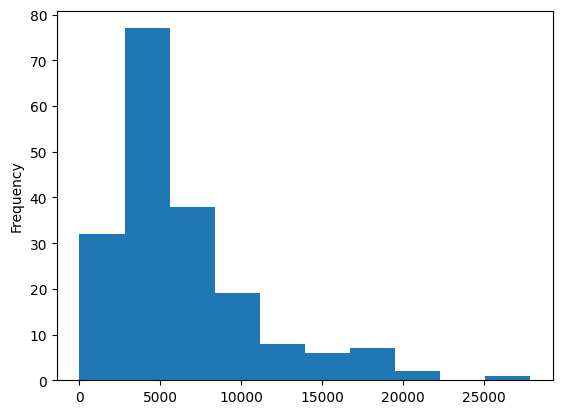

In [422]:
df2[(df2.HomePlanet == 'Europa') & (df2.Destination == 'TRAPPIST-1e') & (df2.Deck == 'C') & (df2.Side == 'S') & (df2.CryoSleep == False)].Bills.plot(kind='hist')

In [406]:
df2.iloc[421]

PassengerId                   0310_01
HomePlanet                     Europa
CryoSleep                       False
Cabin                             NaN
Destination               TRAPPIST-1e
Age                              67.0
VIP                             False
RoomService                       NaN
FoodCourt                       230.0
ShoppingMall                      0.0
Spa                            4476.0
VRDeck                          241.0
Name                 Naviton Coudered
Set                             Train
Transported                     False
Group                             310
GroupNumber                         1
Deck                              NaN
Number                            NaN
Side                              NaN
FirstName                     Naviton
LastName                     Coudered
GroupSize                           1
Bills                             NaN
potential_decks    [A, B, C, D, E, T]
Name: 421, dtype: object

In [407]:
df2.iloc[404]

PassengerId                   0293_01
HomePlanet                     Europa
CryoSleep                        True
Cabin                             NaN
Destination               TRAPPIST-1e
Age                              47.0
VIP                             False
RoomService                       0.0
FoodCourt                         0.0
ShoppingMall                      0.0
Spa                               0.0
VRDeck                            0.0
Name                 Tauxon Suptibler
Set                              Test
Transported                       NaN
Group                             293
GroupNumber                         1
Deck                              NaN
Number                            NaN
Side                              NaN
FirstName                      Tauxon
LastName                    Suptibler
GroupSize                           1
Bills                             0.0
potential_decks    [A, B, C, D, E, T]
Name: 404, dtype: object

In [376]:
all_cabin_options_for_each_row(df2)


index 404
passenger 0293_01
GroupSize 1
[['B', 'P', 12.0, 14.0], ['C', 'S', 12.0, 14.0]]

index 421
passenger 0310_01
GroupSize 1
[['B', 'P', 12.0, 14.0], ['C', 'S', 12.0, 14.0]]

index 479
passenger 0348_02
GroupSize 2
[['E', 'P', 19.0, 22.0]]

index 505
passenger 0364_02
GroupSize 2
[['E', 'P', 19.0, 22.0]]

index 517
passenger 0374_02
GroupSize 2
[['E', 'P', 19.0, 22.0]]

index 1401
passenger 0992_04
GroupSize 6
[['E', 'P', 57.0, 59.0]]

index 1423
passenger 1006_03
GroupSize 3
[['E', 'P', 57.0, 59.0]]

index 1429
passenger 1011_01
GroupSize 2
[['E', 'P', 57.0, 59.0]]

index 1466
passenger 1041_01
GroupSize 1
[['C', 'S', 39.0, 41.0], ['D', 'S', 35.0, 37.0], ['E', 'P', 57.0, 59.0]]

index 1543
passenger 1095_01
GroupSize 1
[['C', 'S', 39.0, 41.0], ['D', 'S', 35.0, 37.0]]

index 2442
passenger 1709_03
GroupSize 7
[]

index 2970
passenger 2092_03
GroupSize 5
[]

index 3529
passenger 2513_01
GroupSize 1
[['E', 'P', 149.0, 151.0], ['F', 'P', 518.0, 520.0]]

index 3530
passenger 2514_01


In [594]:
df2[df2.Group == 1006]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks,CabinSize
1421,1006_01,Earth,False,E/74/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,...,1,E,74.0,S,Velyne,Summington,3,791.0,None,2.0
1422,1006_02,Earth,True,E/74/S,TRAPPIST-1e,5.0,False,0.0,0.0,0.0,...,2,E,74.0,S,Stany,Summington,3,0.0,None,2.0
1423,1006_03,Earth,False,NaN,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,...,3,NaN,NaN,NaN,Stenny,Summington,3,0.0,"[E, F, G]",NaN


In [515]:
df2['CabinSize'] = df2.groupby('Cabin')['Cabin'].transform('size')


In [505]:
deck_e = df2[df2.Deck == 'E']

# Identify cabins that have multiple occurrences
deck_e.groupby('Cabin').filter(lambda x: len(x) == 3).Side.value_counts()

Side
S    33
P    21
Name: count, dtype: int64

In [436]:
df2[(df2.GroupSize == 2) & (df2.HomePlanet == 'Mars') & (df.Deck == 'E')].iloc[60:120]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
6610,4710_02,Mars,False,E/293/P,TRAPPIST-1e,NaN,False,179.0,0.0,1805.0,...,4710,2,E,293.0,P,Crunde,Cread,2,2115.0,None
6706,4780_01,Mars,False,E/309/S,TRAPPIST-1e,20.0,False,845.0,0.0,46.0,...,4780,1,E,309.0,S,Hont,Teake,2,1014.0,None
6707,4780_02,Mars,True,E/309/S,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,...,4780,2,E,309.0,S,Ranutz,Teake,2,0.0,None
6729,4796_02,Mars,True,E/311/S,NaN,43.0,False,0.0,0.0,0.0,...,4796,2,E,311.0,S,Stmeal,Cre,2,0.0,None
7103,5086_02,Mars,False,E/327/S,TRAPPIST-1e,17.0,False,55.0,0.0,994.0,...,5086,2,E,327.0,S,Muew,Fort,2,1049.0,None
7121,5096_02,Mars,False,E/328/S,TRAPPIST-1e,21.0,False,542.0,0.0,1222.0,...,5096,2,E,328.0,S,Harz,Colte,2,2346.0,None
7458,5345_02,Mars,False,E/333/P,TRAPPIST-1e,NaN,False,134.0,0.0,6.0,...,5345,2,E,333.0,P,Cops,Cheen,2,1590.0,None
7469,5354_02,Mars,False,E/339/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,5354,2,E,339.0,S,Bares,Kraie,2,0.0,None
7567,5423_02,Mars,False,E/341/P,TRAPPIST-1e,28.0,False,142.0,0.0,1878.0,...,5423,2,E,341.0,P,Cranch,Prine,2,2082.0,None
7569,5424_02,Mars,False,E/342/P,TRAPPIST-1e,64.0,False,469.0,700.0,2.0,...,5424,2,E,342.0,P,Docks,Dal,2,1172.0,None


In [512]:
df2.Deck.value_counts()

Deck
F    4308
G    3873
E    1349
B    1156
C    1115
D     735
A     357
T      11
Name: count, dtype: int64

In [513]:
df2[df2.Age > 40].Deck.value_counts()

Deck
F    762
G    559
C    328
B    321
E    277
D    185
A    108
T      3
Name: count, dtype: int64

In [528]:
i = 0

In [583]:
i -= 5
df2[df2.Group == df2[df2.GroupSize > 2].iloc[i].Group]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks,CabinSize
783,0560_01,Earth,False,G/81/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,...,1,G,81.0,S,Anniey,Hortez,3,0.0,None,2.0
784,0560_02,Earth,False,G/81/S,PSO J318.5-22,12.0,False,0.0,0.0,0.0,...,2,G,81.0,S,Tonyn,Hortez,3,0.0,None,2.0
785,0560_03,Earth,False,F/103/S,TRAPPIST-1e,44.0,False,1440.0,293.0,74.0,...,3,F,103.0,S,Annah,Josey,3,1839.0,None,1.0


In [521]:
df2[df2.Group == 2513]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks,CabinSize
3529,2513_01,Earth,False,NaN,TRAPPIST-1e,28.0,False,0.0,55.0,0.0,...,1,NaN,NaN,NaN,Loree,Mathison,1,711.0,"[E, F, G]",NaN


e p 58

In [520]:
df2[(df2.Deck == 'F') & (df2.Side == 'S')].CabinSize.value_counts()

CabinSize
1.0    1583
2.0     292
3.0     150
4.0      56
5.0      15
Name: count, dtype: int64

In [514]:
df2[df2.Group == 2092]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
2968,2092_01,Mars,False,D/70/S,TRAPPIST-1e,18.0,False,29.0,0.0,2315.0,...,2092,1,D,70.0,S,Muffs,Blan,5,2345.0,None
2969,2092_02,Mars,False,E/153/S,TRAPPIST-1e,43.0,False,546.0,0.0,41.0,...,2092,2,E,153.0,S,Wins,Stpie,5,1297.0,None
2970,2092_03,Mars,False,NaN,TRAPPIST-1e,13.0,NaN,6726.0,0.0,1605.0,...,2092,3,NaN,NaN,NaN,Cray,Stpie,5,9597.0,"[D, E, F]"
2971,2092_04,Mars,False,F/410/S,TRAPPIST-1e,26.0,False,1751.0,0.0,0.0,...,2092,4,F,410.0,S,NaN,NaN,5,1751.0,None
2972,2092_05,Mars,False,D/70/S,TRAPPIST-1e,22.0,False,2300.0,0.0,22.0,...,2092,5,D,70.0,S,Jur,Stpie,5,2578.0,None


In [489]:
df2[df2.Group == 1011]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
1429,1011_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,1633.0,4.0,49.0,...,1011,1,NaN,NaN,NaN,Camie,Prinson,2,1692.0,"[E, F, G]"
1430,1011_02,Earth,True,G/148/P,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,...,1011,2,G,148.0,P,Kaye,Prinson,2,0.0,None


In [472]:
df2[(df2.VIP == True) ].CryoSleep.value_counts

GroupSize
1    119
2     82
3     33
4     23
5      8
6      6
7      2
Name: count, dtype: int64

In [484]:
df2.VIP.value_counts()

VIP
False    12401
True       273
Name: count, dtype: int64

In [485]:
df2[df2.Cabin.isna()].iloc[:50]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
404,0293_01,Europa,True,NaN,TRAPPIST-1e,47.0,False,0.0,0.0,0.0,...,293,1,NaN,NaN,NaN,Tauxon,Suptibler,1,0.0,"[A, B, C, D, E, T]"
421,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,...,310,1,NaN,NaN,NaN,Naviton,Coudered,1,NaN,"[A, B, C, D, E, T]"
479,0348_02,Mars,NaN,NaN,TRAPPIST-1e,36.0,False,520.0,0.0,1865.0,...,348,2,NaN,NaN,NaN,Weet,Mane,2,2385.0,"[D, E, F]"
505,0364_02,Mars,False,NaN,TRAPPIST-1e,37.0,False,731.0,0.0,517.0,...,364,2,NaN,NaN,NaN,Anakes,Chité,2,1298.0,"[D, E, F]"
517,0374_02,Earth,False,NaN,TRAPPIST-1e,36.0,False,6.0,0.0,0.0,...,374,2,NaN,NaN,NaN,Tamie,Sterreray,2,789.0,"[E, F, G]"
1401,0992_04,Europa,False,NaN,55 Cancri e,35.0,True,8030.0,300.0,0.0,...,992,4,NaN,NaN,NaN,Naosa,Herpumble,6,9766.0,"[A, B, C, D, E, T]"
1423,1006_03,Earth,False,NaN,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,...,1006,3,NaN,NaN,NaN,Stenny,Summington,3,0.0,"[E, F, G]"
1429,1011_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,1633.0,4.0,49.0,...,1011,1,NaN,NaN,NaN,Camie,Prinson,2,1692.0,"[E, F, G]"
1466,1041_01,Europa,True,NaN,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,...,1041,1,NaN,NaN,NaN,Algrafi,Heedry,1,0.0,"[A, B, C, D, E, T]"
1543,1095_01,Europa,True,NaN,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,1095,1,NaN,NaN,NaN,Alhail,Drelcate,1,0.0,"[A, B, C, D, E, T]"


In [459]:
df2[df2.Group == 992]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
1398,0992_01,Europa,False,D/35/S,TRAPPIST-1e,49.0,False,31.0,2727.0,0.0,...,992,1,D,35.0,S,Zino,Kiling,6,3077.0,None
1399,0992_02,Europa,False,D/35/S,TRAPPIST-1e,29.0,False,387.0,942.0,0.0,...,992,2,D,35.0,S,Tareson,Kiling,6,12597.0,None
1400,0992_03,Europa,False,D/35/S,55 Cancri e,46.0,False,1192.0,1736.0,17.0,...,992,3,D,35.0,S,Matan,Herpumble,6,2966.0,None
1401,0992_04,Europa,False,NaN,55 Cancri e,35.0,True,8030.0,300.0,0.0,...,992,4,NaN,NaN,NaN,Naosa,Herpumble,6,9766.0,"[A, B, C, D, E, T]"
1402,0992_05,Europa,True,D/35/S,55 Cancri e,17.0,False,0.0,0.0,0.0,...,992,5,D,35.0,S,Sinon,Kiling,6,0.0,None
1403,0992_06,Europa,False,D/35/S,55 Cancri e,37.0,False,4301.0,791.0,0.0,...,992,6,D,35.0,S,Weidus,Kiling,6,6931.0,None


In [463]:
df2[(df2.VIP == True)].Side.value_counts()

Side
P    142
S    126
Name: count, dtype: int64

In [458]:
df2[df2.Group == 1006]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
1421,1006_01,Earth,False,E/74/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,...,1006,1,E,74.0,S,Velyne,Summington,3,791.0,None
1422,1006_02,Earth,True,E/74/S,TRAPPIST-1e,5.0,False,0.0,0.0,0.0,...,1006,2,E,74.0,S,Stany,Summington,3,0.0,None
1423,1006_03,Earth,False,NaN,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,...,1006,3,NaN,NaN,NaN,Stenny,Summington,3,0.0,"[E, F, G]"


In [457]:
df2[df2.Group == 1011]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Group,GroupNumber,Deck,Number,Side,FirstName,LastName,GroupSize,Bills,potential_decks
1429,1011_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,1633.0,4.0,49.0,...,1011,1,NaN,NaN,NaN,Camie,Prinson,2,1692.0,"[E, F, G]"
1430,1011_02,Earth,True,G/148/P,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,...,1011,2,G,148.0,P,Kaye,Prinson,2,0.0,None


In [377]:
rooms_to_fill(df2) 

{'B': {'P': [13], 'S': []},
 'F': {'P': [519, 1489, 1544], 'S': [1424]},
 'A': {'P': [94], 'S': []},
 'G': {'P': [590, 1157, 1286, 1474], 'S': [579, 1206, 1212, 1282]},
 'C': {'P': [], 'S': [13, 40, 270, 298]},
 'E': {'P': [20, 21, 58, 150, 387], 'S': [528]},
 'D': {'P': [191, 235], 'S': [36]}}